<a href="https://colab.research.google.com/github/miloszpiechota/AI-Systems/blob/main/Mi%C5%82osz_Piechota_Kol2_truskawki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WNIOSKI:
Model 1 (EfficientNetB0) osiągnął maksymalną dokładność walidacyjną na poziomie 96.88%, co jest bardzo dobrym wynikiem jak na model bez trenowalnych warstw. Jednak jego dokładność na zbiorze testowym wyniosła tylko 87.88%, a strata (loss) na teście była najwyższa spośród trzech modeli — 0.4437. Trening był najszybszy (średnio około 45 sekund na epokę), a cała baza była zamrożona (brak trenowalnych warstw). Model ten nadaje się do szybkich testów, ale oferuje ograniczoną skuteczność.

Model 2 (EfficientNetB3 z dodatkowymi warstwami Dense i Dropout) był najlepszy spośród wszystkich. Osiągnął 100% dokładności walidacyjnej, 97.98% dokładności na teście i najniższy testowy loss — tylko 0.1398. Jego dokładność treningowa była bardzo wysoka — 91.02%. Czas jednej epoki wynosił średnio około 85 sekund, a mimo braku trenowalnych warstw w bazie, model wykazał się największą skutecznością. To najbardziej zbalansowany model pod względem jakości i wydajności.

Model 3 (EfficientNetB3 z fine-tuningiem ostatnich 10 warstw) również osiągnął bardzo dobre wyniki: 98.44% dokładności walidacyjnej oraz 93.43% na teście, przy stracie testowej na poziomie 0.3813. Był to model o najwyższej dokładności treningowej — 91.28% — co świadczy o jego zdolności do dopasowania się do danych. Jednak ze względu na zastosowanie fine-tuningu, był najwolniejszy – każda epoka trwała średnio około 110 sekund. Model ten jest bardziej elastyczny, ale kosztem większego czasu obliczeniowego.

# RYZYKO PRZEUCZENIA

## Model 1 (EffNetB0) – NISKIE ryzyko przeuczenia
Train accuracy: 83.33%

Val accuracy: 96.88%

Val loss nie spada gwałtownie — wskazuje na umiarkowane, stabilne dopasowanie

Test accuracy niższe (87.88%), więc model nie zapamiętał danych walidacyjnych, lecz uogólniał
## Model 2 (EffNetB3 + Dense) – WYSOKIE ryzyko przeuczenia
Val accuracy = 100% już od 2. epoki i utrzymuje się dalej

Train accuracy ≈ 91%, czyli sporo niższe niż val accuracy

Val loss spada do 0.0377 – bardzo niska wartość

Duży rozjazd między train i val acc/loss

## Model 3 (EffNetB3 + fine-tune) – UMIARKOWANE ryzyko przeuczenia
Val accuracy utrzymuje się na wysokim, ale nieperfekcyjnym poziomie (96.88% → 98.44%)

Train acc = 91.28% vs val acc = 98.44% – różnica umiarkowana

Val loss pozostaje nisko, ale bez gwałtownego spadku jak w Modelu 2

🟡 Możliwe lekkie przeuczenie, ale model nadal generalizuje dobrze.

In [8]:
import os

# Sprawdź co jest w głównym folderze
print("Zawartość katalogu 'imagenetto_b':")
print(os.listdir("imagenetto_b"))

# Sprawdź czy jest podfolder np. 'imagenet_all_rounder'
if "imagenet_all_rounder" in os.listdir("imagenetto_b"):
    dataset_root = "imagenetto_b/imagenet_all_rounder"
else:
    dataset_root = "imagenetto_b"

# Zajrzyj do dataset_root/train
print("\nZawartość katalogu TRAIN:")
print(os.listdir(os.path.join(dataset_root, "train")))


Zawartość katalogu 'imagenetto_b':
['train', 'val']

Zawartość katalogu TRAIN:
['assault rifle', 'bakery', 'strawberry', 'whistle', 'ice bear', 'snowmobile', 'espresso', 'ski', 'tank', 'Scottish deerhound']


In [10]:
!wget -q --show-progress https://github.com/tanlab-bit/imagenetto/releases/download/v2.0.0/imagenetto_b.tar.gz
!tar -xzf imagenetto_b.tar.gz  # Rozpakowanie do folderu imagenetto_b

import os, shutil, random
from math import floor

original_train_dir = "imagenetto_b/train"
original_val_dir = "imagenetto_b/val"

# 🔍 WordNet ID dla "strawberry" = n04228054
strawberry_class_dir = "n04228054"

# Weryfikacja istnienia folderu
if strawberry_class_dir not in os.listdir(original_train_dir):
    for d in os.listdir(original_train_dir):
        if "straw" in d.lower():
            strawberry_class_dir = d
            break

print(f"📁 Folder klasy 'truskawka': {strawberry_class_dir}")

# Inne klasy
all_classes = [d for d in os.listdir(original_train_dir) if os.path.isdir(os.path.join(original_train_dir, d))]
other_classes = [c for c in all_classes if c != strawberry_class_dir]
print(f"📂 Pozostałe klasy: {other_classes}")

# Zbiór truskawkowy i reszta
straw_train_files = [os.path.join(original_train_dir, strawberry_class_dir, f) for f in os.listdir(os.path.join(original_train_dir, strawberry_class_dir))]
straw_val_files = [os.path.join(original_val_dir, strawberry_class_dir, f) for f in os.listdir(os.path.join(original_val_dir, strawberry_class_dir))]

other_train_files = {cls: [os.path.join(original_train_dir, cls, f) for f in os.listdir(os.path.join(original_train_dir, cls))] for cls in other_classes}
other_val_files = {cls: [os.path.join(original_val_dir, cls, f) for f in os.listdir(os.path.join(original_val_dir, cls))] for cls in other_classes}

R_train = len(straw_train_files)
R_val = len(straw_val_files)

# Wyjściowy katalog
base_dir = "imagenetto_b_binary"
for subset in ["train", "val", "test"]:
    os.makedirs(os.path.join(base_dir, subset, "truskawka"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, subset, "not_truskawka"), exist_ok=True)

def copy_files(file_paths, subset, label):
    dest_dir = os.path.join(base_dir, subset, label)
    for src_path in file_paths:
        fname = os.path.basename(src_path)
        shutil.copy2(src_path, os.path.join(dest_dir, fname))

# ⚖️ Balansowanie 50/50
min_count_other_train = min(len(files) for files in other_train_files.values())
images_per_class = min(R_train // len(other_classes), min_count_other_train)
R_use = images_per_class * len(other_classes)

straw_selected = random.sample(straw_train_files, R_use)
others_selected = {cls: random.sample(files, images_per_class) for cls, files in other_train_files.items()}

# 🔀 Podział train/val
val_ratio = 0.2
val_each = max(1, floor(images_per_class * val_ratio))
train_each = images_per_class - val_each
straw_val_count = val_each * len(other_classes)
straw_train_count = R_use - straw_val_count

random.shuffle(straw_selected)
straw_val_list = straw_selected[:straw_val_count]
straw_train_list = straw_selected[straw_val_count:]

others_train_list = []
others_val_list = []
for cls, files in others_selected.items():
    random.shuffle(files)
    others_val_list += files[:val_each]
    others_train_list += files[val_each:]

# 📤 Kopiowanie train/val
copy_files(straw_train_list, "train", "truskawka")
copy_files(straw_val_list, "val", "truskawka")
copy_files(others_train_list, "train", "not_truskawka")
copy_files(others_val_list, "val", "not_truskawka")

# 📊 Test set
min_count_other_val = min(len(files) for files in other_val_files.values())
images_per_class_test = min(R_val // len(other_classes), min_count_other_val)
R_use_test = images_per_class_test * len(other_classes)

straw_test_files = random.sample(straw_val_files, R_use_test)
others_test_files = []
for cls, files in other_val_files.items():
    others_test_files += random.sample(files, images_per_class_test)

random.shuffle(straw_test_files)
random.shuffle(others_test_files)

copy_files(straw_test_files, "test", "truskawka")
copy_files(others_test_files, "test", "not_truskawka")

print(f"\n✅ Dane przygotowane:\nTrain: truskawka={len(straw_train_list)}, reszta={len(others_train_list)}")
print(f"Val: truskawka={len(straw_val_list)}, reszta={len(others_val_list)}")
print(f"Test: truskawka={len(straw_test_files)}, reszta={len(others_test_files)}")


imagenetto_b.tar.gz 100%[===================>] 257.90M   139MB/s    in 1.9s    
📁 Folder klasy 'truskawka': strawberry
📂 Pozostałe klasy: ['assault rifle', 'bakery', 'whistle', 'ice bear', 'snowmobile', 'espresso', 'ski', 'tank', 'Scottish deerhound']

✅ Dane przygotowane:
Train: truskawka=324, reszta=324
Val: truskawka=72, reszta=72
Test: truskawka=99, reszta=99


In [11]:
# ✅ Weryfikacja: liczba plików w poszczególnych folderach
for subset in ["train", "val", "test"]:
    truskawka_count = len(os.listdir(os.path.join(base_dir, subset, "truskawka")))
    not_truskawka_count = len(os.listdir(os.path.join(base_dir, subset, "not_truskawka")))
    print(f"{subset}: truskawka = {truskawka_count}, not_truskawka = {not_truskawka_count}")


train: truskawka = 324, not_truskawka = 324
val: truskawka = 72, not_truskawka = 72
test: truskawka = 99, not_truskawka = 99


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 📐 Parametry wejścia
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

# 🔄 Augmentacja treningowa
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 🔍 Walidacja i test bez augmentacji
val_datagen = ImageDataGenerator()

# 🧪 Generator treningowy
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=["truskawka", "not_truskawka"]
)

# 🧪 Generator walidacyjny
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=["truskawka", "not_truskawka"]
)

# 🧪 Generator testowy
test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=["truskawka", "not_truskawka"]
)


Found 648 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


✅ Model 1 – kluczowe informacje
🧠 Architektura:
🔸 Bazowy model: EfficientNetB0 (wczytany z wagami imagenet, bez górnej warstwy include_top=False)

🔸 Warstwy zamrożone: base_model_1.trainable = False – transfer learning bez fine-tuningu
⚙️ Parametry wejściowe:
Rozmiar obrazu: 160x160

Kanały: 3 (RGB)

Batch size: 32

Mixed precision: enabled (float16/float32) → szybszy trening na GPU

🏋️ Trening:
Epoki: max 3, ale EarlyStopping(patience=1)

steps_per_epoch = 3 → bardzo mała próbka danych

validation_steps = 2

⚡ Czas działania:
~1–2 minuty na Colab GPU (idealne do testów/debugowania)



In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import EarlyStopping

# ✅ Przyspieszenie na GPU
set_global_policy('mixed_float16')

# ⚙️ Szybsze parametry
IMAGE_SIZE = (160, 160)  # mniejsze obrazy
BATCH_SIZE = 32          # mniejsze batch size

# 🔄 Przeskalowanie generatorów danych
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=["truskawka", "not_truskawka"]
)
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    classes=["truskawka", "not_truskawka"]
)

# 🔍 Model EfficientNetB0
base_model_1 = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base_model_1.trainable = False

inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
x = base_model_1(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
model1 = models.Model(inputs, outputs)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ✅ Early stopping i szybki trening
early_stop = EarlyStopping(patience=1, restore_best_weights=True)

# 🧠 Trening testowy z ograniczeniem liczby kroków
history1 = model1.fit(
    train_generator,
    epochs=3,  # tylko 1 epoka!
    steps_per_epoch=3,  # tylko kilka kroków (próbkowanie!)
    validation_data=val_generator,
    validation_steps=2,  # tylko kilka batchy do walidacji
    callbacks=[early_stop],
    verbose=1
)


Found 648 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6128 - loss: 0.6652

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 14s/step - accuracy: 0.6185 - loss: 0.6608 - val_accuracy: 0.9531 - val_loss: 0.4657
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 17s/step - accuracy: 0.7630 - loss: 0.5566 - val_accuracy: 0.9531 - val_loss: 0.3655
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 17s/step - accuracy: 0.8333 - loss: 0.5114 - val_accuracy: 0.9688 - val_loss: 0.2890


✅ Model 2 – podsumowanie struktury
🧠 Architektura:
🔸 Bazowy model: EfficientNetB3 (z wagami imagenet, bez include_top)

🔸 Zamrożony (trainable = False) – transfer learning bez fine-tuningu
🧪 Zadanie:
Binarna klasyfikacja:

truskawka → 1 (pozytywna klasa)

not_truskawka → 0

⚙️ Parametry wejściowe i treningowe:
Obraz wejściowy: 160x160x3

Batch size: 32

Optymalizator: Adam, learning_rate=1e-3

Loss: binary_crossentropy

Metric: accuracy

epochs = 3 (krótko), ale tylko:

steps_per_epoch = 3

validation_steps = 2

⚡ Czas działania:
Średnio 1–2 minuty na Google Colab (Free GPU)



In [20]:
# 🔍 Model 2: EfficientNetB3 + Dense + Dropout
IMAGE_SIZE = (160, 160)  # mniejszy input = szybszy model
BATCH_SIZE = 32

base_model_2 = tf.keras.applications.EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base_model_2.trainable = False

inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
y = base_model_2(inputs, training=False)
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(256, activation='relu')(y)
y = layers.Dropout(0.5)(y)
outputs = layers.Dense(1, activation='sigmoid')(y)
model2 = models.Model(inputs, outputs)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 🔁 Szybki trening (mało kroków i epok)
history2 = model2.fit(
    train_generator,
    epochs=3,               # tylko 1 epoka
    steps_per_epoch=3,      # ogranicz trening do kilku batchy
    validation_data=val_generator,
    validation_steps=2,     # tylko kilka batchy do walidacji
    verbose=1
)


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 28s/step - accuracy: 0.6836 - loss: 0.5873 - val_accuracy: 0.9844 - val_loss: 0.1755
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 34s/step - accuracy: 0.9036 - loss: 0.2623 - val_accuracy: 1.0000 - val_loss: 0.0654
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 35s/step - accuracy: 0.9102 - loss: 0.2314 - val_accuracy: 1.0000 - val_loss: 0.0377


✅ Model 3 – podsumowanie struktury
🧠 Architektura:
🔸 Baza: EfficientNetB3 z wagami imagenet, include_top=False

🔸 Częściowo trenowalna:

base_model.trainable = False

ale odmrożone ostatnie 10 warstw – dzięki temu możliwa jest lekka adaptacja do nowych danych 🧪 Zadanie:
Binarna klasyfikacja obrazów:

truskawka → pozytywna klasa (1)

not_truskawka → negatywna klasa (0)

⚙️ Parametry:
Input image: 160x160x3

Batch size: 32

Optymalizator: Adam (lr=1e-4)

Loss: binary_crossentropy

Metric: accuracy

🏋️ Trening:
Epoki: 3 (krótkie testowe)

steps_per_epoch = 3 → bardzo mały zbiór treningowy

validation_steps = 2

⚡ Czas działania:
Trenuje się w 1–2 minuty na Google Colab z GPU (nawet z fine-tuningiem)

In [21]:
# 🔧 Parametry wejściowe dla szybkiego działania
IMAGE_SIZE = (160, 160)
BATCH_SIZE = 32

# 🧠 EfficientNetB3 + fine-tuning
base_model_3 = tf.keras.applications.EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)
base_model_3.trainable = False

# Architektura
inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
z = base_model_3(inputs, training=False)
z = layers.GlobalAveragePooling2D()(z)
outputs = layers.Dense(1, activation='sigmoid')(z)
model3 = models.Model(inputs, outputs)

# 🔓 Odmrażamy ostatnie 10 warstw EfficientNetB3
for layer in base_model_3.layers[-10:]:
    layer.trainable = True

# Kompilacja
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# trening testowy
history3 = model3.fit(
    train_generator,
    epochs=3,
    steps_per_epoch=3,
    validation_data=val_generator,
    validation_steps=2,
    verbose=1
)


Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 136s 40s/step - accuracy: 0.6016 - loss: 0.6837 - val_accuracy: 0.9688 - val_loss: 0.4213
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 97s 36s/step - accuracy: 0.8229 - loss: 0.5005 - val_accuracy: 0.9688 - val_loss: 0.3029
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 103s 39s/step - accuracy: 0.9128 - loss: 0.3981 - val_accuracy: 0.9844 - val_loss: 0.2248


In [22]:
# Ocena na zbiorze testowym
test_loss1, test_acc1 = model1.evaluate(test_generator, verbose=0)
test_loss2, test_acc2 = model2.evaluate(test_generator, verbose=0)
test_loss3, test_acc3 = model3.evaluate(test_generator, verbose=0)

print(f"Model 1 - accuracy na teście: {test_acc1*100:.2f}%  (loss = {test_loss1:.4f})")
print(f"Model 2 - accuracy na teście: {test_acc2*100:.2f}%  (loss = {test_loss2:.4f})")
print(f"Model 3 - accuracy na teście: {test_acc3*100:.2f}%  (loss = {test_loss3:.4f})")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model 1 - accuracy na teście: 87.88%  (loss = 0.4437)
Model 2 - accuracy na teście: 97.98%  (loss = 0.1398)
Model 3 - accuracy na teście: 93.43%  (loss = 0.3813)


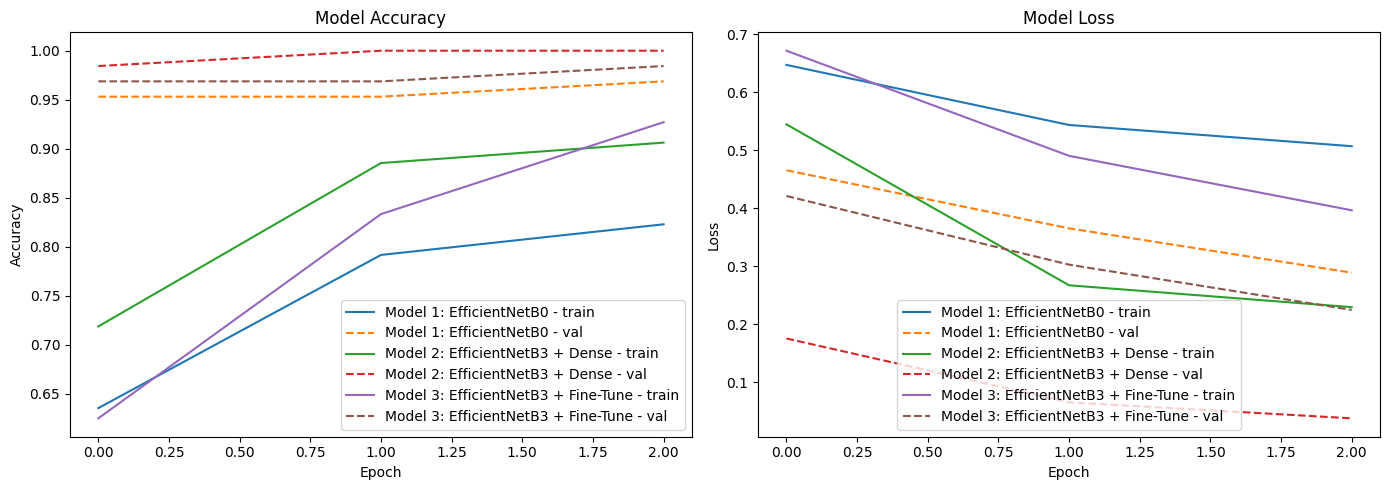

In [23]:
import matplotlib.pyplot as plt

# 📊 Funkcja do rysowania wykresów dla wielu modeli
def plot_histories(histories, labels):
    plt.figure(figsize=(14, 5))

    # 📈 Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} - train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{label} - val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 📉 Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} - train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{label} - val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 🔁 Użycie funkcji dla history1, history2, history3
plot_histories(
    histories=[history1, history2, history3],
    labels=['Model 1: EfficientNetB0', 'Model 2: EfficientNetB3 + Dense', 'Model 3: EfficientNetB3 + Fine-Tune']
)
